# Noto Emoji -> Hugging Face Dataset

References for dataset scripts:
- https://huggingface.co/datasets/squad/blob/main/squad.py

References for color emoji fonts:
- https://www.youtube.com/watch?v=BmqYm5Wwz8M

## Get emojis from unicode_data

In [65]:
import itertools
from nototools import unicode_data
import os
from dataclasses import dataclass
svg_directory = './svg'
png_directory = './png'

import re

def strip_emoji_version(str):
    # E3.0 prince -> prince
    # (emoji) digit one -> digit one
    # (emoji) E0.6 copyright -> copyright
    return re.sub(r'(?:\(emoji\))? ?(?:E\d+\.\d+ )?(.*)', r'\1', str)



def gen_emojis():
    for group in unicode_data.get_emoji_groups()[:2]:
        for seq in unicode_data.get_emoji_in_group(group):
            # name = _custom_name(seq) or _standard_name(seq)
            name = unicode_data.get_emoji_sequence_name(seq)
            # 'E1.0 grinning face' -> 'grinning face'
            name = strip_emoji_version(name)
            yield seq, name

In [64]:
def path_for_codepoint(seq, is_svg=True):
    if is_svg:
        return os.path.join(svg_directory, f"{name_for_codepoint(seq)}.svg")
    else:
        return os.path.join(png_directory, "512", f"{name_for_codepoint(seq)}.png")

def name_for_codepoint(seq):
    hex_seq = [hex(s)[2:] for s in seq]
    return f"emoji_u{'_'.join(hex_seq)}"

def seq_as_emoji(seq):
    return ''.join(chr(c) for c in seq)

# print first 100 emojis
first_100 = itertools.islice(((s, n, path_for_codepoint(s), seq_as_emoji(s)) for s, n in gen_emojis()), 100)
# [print(seq, name, path_for_codepoint(seq))
#  for seq, name in first_100]

list(first_100)

[((128512,), 'E1.0 grinning face', './svg/emoji_u1f600.svg', '😀'),
 ((128515,),
  'E0.6 grinning face with big eyes',
  './svg/emoji_u1f603.svg',
  '😃'),
 ((128516,),
  'E0.6 grinning face with smiling eyes',
  './svg/emoji_u1f604.svg',
  '😄'),
 ((128513,),
  'E0.6 beaming face with smiling eyes',
  './svg/emoji_u1f601.svg',
  '😁'),
 ((128518,), 'E0.6 grinning squinting face', './svg/emoji_u1f606.svg', '😆'),
 ((128517,), 'E0.6 grinning face with sweat', './svg/emoji_u1f605.svg', '😅'),
 ((129315,),
  'E3.0 rolling on the floor laughing',
  './svg/emoji_u1f923.svg',
  '🤣'),
 ((128514,), 'E0.6 face with tears of joy', './svg/emoji_u1f602.svg', '😂'),
 ((128578,), 'E1.0 slightly smiling face', './svg/emoji_u1f642.svg', '🙂'),
 ((128579,), 'E1.0 upside-down face', './svg/emoji_u1f643.svg', '🙃'),
 ((129760,), 'E14.0 melting face', './svg/emoji_u1fae0.svg', '\U0001fae0'),
 ((128521,), 'E0.6 winking face', './svg/emoji_u1f609.svg', '😉'),
 ((128522,),
  'E0.6 smiling face with smiling eyes',
  '.

In [20]:
seq, name = next(gen_emojis())
path_for_codepoint(seq)

'./svg/emoji_u1f600.svg'

### Render SVG -> PNG (optional)

It looks like the rendering isn't as high-quality as the PNGs in this repo, unfortunately.
So, sticking with the existing PNGs for now.

Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.43,100.73'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.43,100.73'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.43,101'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.49,74.66'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.49,74.66'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.43,101'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.42,100.89'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.49,74.7'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.49,74.7'.
Warning (in usvg::svgtree::parse:62): Failed to parse d value: 'M63.42,100.89'.


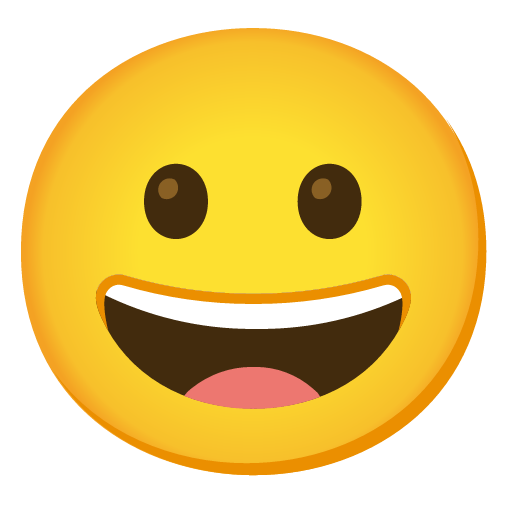

In [25]:
# see ./generate_emoji_thumbnails.py
import subprocess
from PIL import Image

def create_thumbnail(src_path, dst_path, size = (512, 512)):
  # Uses resvg
    cmd = ['resvg', src_path, dst_path, f'--width={size[0]}', f'--height={size[1]}']
    subprocess.check_call(cmd)

create_thumbnail(path_for_codepoint(seq), 'test.png')
Image.open('test.png')

In [ ]:
# convert all emojis to png 

## Define imagefolder dataset, write metadata in jsonl format

todo: 
- [x] add metadata to jsonl
- [x] optimize svg files
- [x] fix fe0f errors (variant selector is not included in the filename)
- [ ] load svg text like images instead of inlining them into the parquet

In [132]:
from dataclasses import asdict
import json
import shutil
from tqdm import tqdm
from svg_cleaner import SvgCleaner

cleaner = SvgCleaner()

@dataclass
class EmojiBitmapVectorRow:
    codepoints: bytes
    name: str
    text: str
    svg_path: str
    file_name: str
    svg_text: str

result_dir = './dataset'

errors = []
records = []
# create a jsonl ImageDataset for huggingface datasets
with open(os.path.join(result_dir, "metadata.jsonl"), 'w') as meta:
    for seq, name in tqdm(gen_emojis()):
        seq_clean = unicode_data.strip_emoji_vs(seq)
        svg_path = path_for_codepoint(seq_clean)
        png_path = path_for_codepoint(seq_clean, is_svg=False)
        text = seq_as_emoji(seq)
        try:
            # copy the svg and png files to the ./dataset directory
            shutil.copy(svg_path, result_dir)
            shutil.copy(png_path, result_dir)
            with open(svg_path, 'r') as svg_file:
                svg_text = svg_file.read()
                svg_text = cleaner.clean_svg(svg_text)

            record = EmojiBitmapVectorRow(seq, name, text, f"{name_for_codepoint(seq_clean)}.svg", f"{name_for_codepoint(seq_clean)}.png", svg_text)
            records.append(record)
            meta.write(json.dumps(asdict(record)) + '\n')
        except Exception as e:
            errors.append((text, svg_path, png_path, name, e))

print('Records: ', len(records))
print('Errors: ', len(errors), errors[0] if len(errors) > 0 else None)


2329it [00:03, 697.91it/s]

Records:  2329
Errors:  0 None


In [129]:

before = records[0].svg_text
after = cleaner.clean_svg(before)
print(f"len before: {len(before)}, len after: {len(after)}")
after

len before: 3806, len after: 3806


'<svg width="128" height="128" style="enable-background:new 0 0 128 128;" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n  <g id="facial_expressions">\n    <radialGradient id="face_1_" cx="63.22" cy="216.9" gradientTransform="matrix(1 0 0 1 0 -154)" gradientUnits="userSpaceOnUse" r="56.9597">\n      <stop offset="0.5" style="stop-color:#FDE030"/>\n      <stop offset="0.92" style="stop-color:#F7C02B"/>\n      <stop offset="1" style="stop-color:#F4A223"/>\n    </radialGradient>\n    <path id="face" d="M63.22,118.8c-27.9,0-58-17.5-58-55.9S35.32,7,63.22,7c15.5,0,29.8,5.1,40.4,14.4 c11.5,10.2,17.6,24.6,17.6,41.5s-6.1,31.2-17.6,41.4C93,113.6,78.62,118.8,63.22,118.8z" style="fill:url(#face_1_);"/>\n    <path d="M44,40.94L44,40.94c-4.19,0-8,3.54-8,9.42s3.81,9.41,8,9.41l0,0c4.2,0,8-3.54,8-9.41 S48.24,40.94,44,40.94z" style="fill:#422B0D;"/>\n    <g id="peepers">\n      <path d="M43.65,44.87L43.65,44.87c-1.42-0.68-3.13-0.08-3.82,1.34c-0.53,1.11-0.29,2.44,0.6,3.3l

In [130]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


Resolving data files: 100%|██████████| 4659/4659 [00:00<00:00, 75238.57it/s]


Extracting data files: 100%|██████████| 2329/2329 [00:00<00:00, 7239.39it/s]


Dataset imagefolder downloaded and prepared to /Users/andrew/.cache/huggingface/datasets/imagefolder/emojis-3b8ad0a4b9260f1e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
sample:  {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512 at 0x16A20CA00>, 'codepoints': [127877], 'name': 'Santa Claus', 'text': '🎅', 'svg_path': 'emoji_u1f385.svg', 'svg_text': '<svg width="128" height="128" style="enable-background:new 0 0 128 128;" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n  <linearGradient id="SVGID_1_" gradientTransform="matrix(1 0 0 -1 0 130)" gradientUnits="userSpaceOnUse" x1="27.61" x2="105.4818" y1="97.1075" y2="97.1075">\n    <stop offset="0" style="stop-color:#F44336"/>\n    <stop offset="0.3592" style="stop-color:#E73B32"/>\n    <stop offset="1" style="stop-color:#C62828"/>\n  </linearGradient>\n  <path d="M90.92,11.55C85.56,7.07,77.56,4.3,63.59,4.3c-25.64,0-35.98,

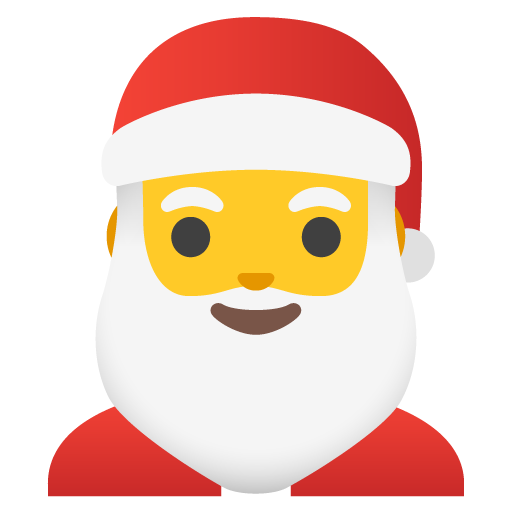

In [133]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='./dataset', name='emojis', split='train')

# sample from the dataset
print("sample: ", dataset[0])
dataset[0]['image']

In [134]:
dataset[0]['svg_text']

'<svg width="128" height="128" style="enable-background:new 0 0 128 128;" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n  <linearGradient id="SVGID_1_" gradientTransform="matrix(1 0 0 -1 0 130)" gradientUnits="userSpaceOnUse" x1="27.61" x2="105.4818" y1="97.1075" y2="97.1075">\n    <stop offset="0" style="stop-color:#F44336"/>\n    <stop offset="0.3592" style="stop-color:#E73B32"/>\n    <stop offset="1" style="stop-color:#C62828"/>\n  </linearGradient>\n  <path d="M90.92,11.55C85.56,7.07,77.56,4.3,63.59,4.3c-25.64,0-35.98,16.53-35.98,36.87 c0,0.08,2.42,0.25,2.91,0.29c0.06,0,0.11,0.01,0.17,0.01L64,32c0,0,30.06,9.38,30.31,10.22l5.69,17.51 c0.31,1.04,1.26,1.75,2.35,1.75c1.29,0,2.36-1,2.45-2.29c0.18-2.87,0.48-8.01,0.62-12.9C105.62,38.86,106.28,24.38,90.92,11.55z" style="fill:url(#SVGID_1_);"/>\n  <ellipse cx="101.91" cy="63.86" rx="6.75" ry="6.75" style="fill:#E0E0E0;"/>\n  <g id="robe">\n    <linearGradient id="SVGID_2_" gradientTransform="matrix(1 0 0 -1

In [135]:
dataset.push_to_hub('darknoon/noto-emoji-vector-512-svg')

Deleting unused files from dataset repository: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


In [144]:
test_train_dataset = dataset.train_test_split(0.2, seed=42)
test_train_dataset["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512>,
 'codepoints': [9994, 127998],
 'name': 'raised fist: medium-dark skin tone',
 'text': '✊🏾',
 'svg_path': 'emoji_u270a_1f3fe.svg',
 'svg_text': '<svg width="128" height="128" style="enable-background:new 0 0 128 128;" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n  <path d="M117.35,22.51c-0.09-6.46-7.4-12.03-12.23-13.15c-4.83-1.13-13.78-1.04-15.95,6.52 c0,0-0.15-0.66-0.2-1.18C88.1,6.54,79.79,4,73.87,4C68.43,4,58.13,6.78,58.8,15.05l-1.73-0.07c-1.46-5.16-10.81-6.96-17.85-5.05 c-4.78,1.3-12.37,7.42-9.86,15.78c0.21,0.7,0.45,1.45,0.71,2.22c-5.19-4.83-10.77-5.55-15.8-3.19c-5.37,2.51-8.25,7.31-6.33,14.54 c0.08,0.29,0.17,0.58,0.25,0.87c-1.44,13.75-1.16,34.15,4.06,47.59c11.81,30.42,32.56,33.25,45.3,33.63 c55.62,1.67,60.43-38.42,60.27-43.73c-0.16-5.18,0.02-13.69-2.09-18.31C115.73,59.32,117.4,26.25,117.35,22.51z" style="fill:#A56C43;"/>\n  <path d="M32.46,79.56c3.11,1.88,6.63,3.95,9.64,5.98